In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/testset/testset.json
/kaggle/input/retrieval-testset/retrieval_testset.json
/kaggle/input/vietnam-history-dataset/vietnam_history_dataset.csv


In [3]:
# Install required libraries
!pip install vllm
!pip install langchain-community
!pip install sentence-transformers
!pip install rank_bm25
!pip install chromadb
!pip install underthesea
!pip install huggingface_hub
!pip install gradio
!pip uninstall torch torchvision torchaudio -y

  Using cached torch-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached torchaudio-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.6 kB)
  Using cached torchvision-0.22.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached triton-3.3.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (1.5 kB)
Using cached torch-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl (865.2 MB)
Using cached torchaudio-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl (3.5 MB)
Using cached torchvision-0.22.0-cp311-cp311-manylinux_2_28_x86_64.whl (7.4 MB)
Using cached triton-3.3.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (156.5 MB)
  Attempting uninstall: triton
    Found existing installation: triton 3.3.1
    Uninstalling triton-3.3.1:
      Successfully uninstalled triton-3.3.1
  Attempting uninstall: torch
    Found existing installation: torch 2.7.1+cu126
    Uninstalling torch-2.7.1+cu126:
      Successfully uninstalled torch-2

In [4]:
!nvidia-smi

Sun Jun  8 17:29:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# solve the dependencies when using the vLLM
CUDA_VERSION = "cu126"

print(f"\nInstalling torch, torchvision, torchaudio for CUDA {CUDA_VERSION}...")
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/{CUDA_VERSION}


Installing torch, torchvision, torchaudio for CUDA cu126...
Looking in indexes: https://download.pytorch.org/whl/cu126
  Using cached https://download.pytorch.org/whl/cu126/torch-2.7.1%2Bcu126-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached https://download.pytorch.org/whl/cu126/torchvision-0.22.1%2Bcu126-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.7.1%2Bcu126-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.6 kB)
  Using cached https://download.pytorch.org/whl/triton-3.3.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (1.5 kB)
Using cached https://download.pytorch.org/whl/cu126/torch-2.7.1%2Bcu126-cp311-cp311-manylinux_2_28_x86_64.whl (822.1 MB)
Using cached https://download.pytorch.org/whl/triton-3.3.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (155.7 MB)
Using cached https://download.pytorch.org/whl/cu126/torchvision-0.22.1%2Bcu126-cp311-cp31

In [6]:
import pandas as pd

# vietnam hisory dataset is crawled from Wikipages (1000 pages)
data_path = "/kaggle/input/vietnam-history-dataset/vietnam_history_dataset.csv"

try:
    # Load the CSV file
    df = pd.read_csv(data_path)

    print(f"\nDataset Info:")
    df.info()
    
except FileNotFoundError:
    print(f"\nError: The file 'vietnam_history_dataset.csv' was not found. Please check the file path.")
    
except pd.errors.ParseError:
    print(f"\nError: Failed to parse the CSV file. Please ensure the file is a valid CSV format.")
    
except Exception as e:
    print(f"An unexpected error occurred: {str(e)}")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      1000 non-null   object
 1   content    1000 non-null   object
 2   url        1000 non-null   object
 3   timestamp  1000 non-null   object
dtypes: object(4)
memory usage: 31.4+ KB


In [16]:
# helper function
from underthesea import word_tokenize, sent_tokenize
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Initialize text splitter for semantic chunking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  
    chunk_overlap=200,  # Overlap to maintain context
    length_function=lambda x: len(word_tokenize(x)),  # Vietnamese token counting
    separators=["\n\n", "\n", ". ", " ", ""],  # Prioritize sentence/paragraph breaks
    add_start_index=True
)

# Preprocess Vietnamese text with sentence splitting
def preprocess_vietnamese_text(text):
    # Split into sentences and tokenize each sentence
    sentences = sent_tokenize(text.lower())
    return '\n'.join([' '.join(word_tokenize(sent)) for sent in sentences])

# Create document objects with chunking
def create_document(row, index):
    try:
        # Construct full content
        full_content = f"title: {row.get('title', '')}. content: {row.get('content', '')}. url: {row.get('url', '')}."
        # Preprocess content for Vietnamese
        preprocessed_content = preprocess_vietnamese_text(full_content)
        # Split into chunks
        chunks = text_splitter.split_text(preprocessed_content)
        documents = []
        for i, chunk in enumerate(chunks):
            metadata = {
                "source": "vietnam_history_dataset",
                "row_id": f"{index}_{i}",  # Use index instead of row.name
                "title": row.get("title", ""),
                "url": row.get("url", ""),
                "chunk_index": i,
                **row.to_dict()
            }
            documents.append(Document(page_content=chunk.strip(), metadata=metadata))
        return documents
    except Exception as e:
        print(f"Error processing row {index}: {e}")
        return None

In [17]:
# Filter out rows
df_filtered = df[df[['title', 'content', 'url']].notna().any(axis=1)]

# DataFrame
df_filtered = df_filtered.reset_index(drop=True)

# Create chunked documents
docs = []
for index, row in df_filtered.iterrows():
    result = create_document(row, index)
    if result:
        docs.extend(result) if isinstance(result, list) else docs.append(result)

print(f"\nNumber of documents after semantic chunking: {len(docs)}")
if docs:
    print(f"\nExample document content (first 1000 chars): {docs[0].page_content[:1000]}...")
    print(f"\nExample document metadata: {docs[0].metadata}")


Number of documents after semantic chunking: 2470

Example document content (first 1000 chars): title : lịch sử việt nam .
content : lịch sử việt nam nếu tính từ lúc có mặt con người sinh sống thì đã có hàng vạn năm trước công nguyên , còn tính từ khi cơ cấu nhà nước được hình thành thì vào khoảng từ năm 700 năm trước công nguyên .
các nhà khảo cổ đã tìm thấy các di tích chứng minh loài người đã từng sống tại việt nam từ thời đại đồ đá cũ thuộc nền văn hóa tràng an , ngườm , sơn vi và soi nhụ .
vào thời kỳ đồ đá mới , nền văn hóa hòa bình – bắc sơn tại vùng này đã phát triển về chăn nuôi và nông nghiệp , đặc biệt là kỹ thuật trồng lúa nước .
những người việt tiền sử trên vùng châu thổ sông hồng – văn minh sông hồng và sông mã này đã khai hóa đất để trồng trọt , tạo ra một hệ thống đê điều để chế ngự nước lụt của các sông , đào kênh để phục vụ cho việc trồng lúa và đã tạo nên nền văn minh lúa nước và văn hóa làng xã .
truyền thuyết kể rằng từ năm 2879 tcn , nhà nước xích quỷ của người 

In [23]:
# Print first 50 chunks
print("\nFirst 50 chunks:")
for i, doc in enumerate(docs[:50]):
    content_preview = doc.page_content[:500] + ("..." if len(doc.page_content) > 500 else "")
    print(f"\nChunk {i + 1}:")
    print(f"Content: {content_preview}")
    print(f"Metadata: {doc.metadata}")


First 50 chunks:

Chunk 1:
Content: title : lịch sử việt nam .
content : lịch sử việt nam nếu tính từ lúc có mặt con người sinh sống thì đã có hàng vạn năm trước công nguyên , còn tính từ khi cơ cấu nhà nước được hình thành thì vào khoảng từ năm 700 năm trước công nguyên .
các nhà khảo cổ đã tìm thấy các di tích chứng minh loài người đã từng sống tại việt nam từ thời đại đồ đá cũ thuộc nền văn hóa tràng an , ngườm , sơn vi và soi nhụ .
vào thời kỳ đồ đá mới , nền văn hóa hòa bình – bắc sơn tại vùng này đã phát triển về chăn nuôi v...
Metadata: {'source': 'vietnam_history_dataset', 'row_id': '0_0', 'title': 'Lịch sử Việt Nam', 'url': 'https://vi.wikipedia.org/wiki/L%E1%BB%8Bch_s%E1%BB%AD_Vi%E1%BB%87t_Nam', 'chunk_index': 0, 'content': 'Lịch sử Việt Nam nếu tính từ lúc có mặt con người sinh sống thì đã có hàng vạn năm trước Công Nguyên, còn tính từ khi cơ cấu nhà nước được hình thành thì vào khoảng từ năm 700 năm trước công nguyên. Các nhà khảo cổ đã tìm thấy các di tích chứng minh loài

In [24]:
from langchain_community.retrievers import BM25Retriever

# Initialize BM25 retriever
bm25_retriever = BM25Retriever.from_documents(docs)
bm25_retriever.k = 10  # Retrieve top 10 documents
print(f"Initialize BM25 retriever done ")

Initialize BM25 retriever done 


In [25]:
from langchain.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

# Embedding model
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

# Initialize embedding model
embedding_model = HuggingFaceEmbeddings(model_name=model_name)

# Create Chroma vector store
vector_store = Chroma.from_documents(docs, embedding_model)

# Initialize semantic retriever
semantic_retriever = vector_store.as_retriever(search_kwargs={"k": 10}) # Retrieve top 10 documents
print(f"Initialize Semantic retriever done ")

/tmp/ipykernel_459/2376014679.py:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name=model_name)
2025-06-08 18:22:01.039514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749406921.057369     459 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749406921.062473     459 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plug

Initialize Semantic retriever done 


In [47]:
from langchain.retrievers import EnsembleRetriever

# Initialize ensemble retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, semantic_retriever],
    weights=[0.7, 0.3]
)
print(f"Initialize Ensemble retriever done")

Initialize Ensemble retriever done


In [33]:
# Evaluate the BM25 Retriever, Semantic Retriever and Ensemble Retriever
# Retrieval Information test set: https://www.kaggle.com/datasets/tungnguyen1010/retrieval-testset (manually prepared)

import json
from typing import Dict, List
from collections import defaultdict

# Function to load JSON test set
def load_test_set(json_path: str) -> Dict[str, List[str]]:
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            test_set = json.load(f)
        # Map query to list of row_ids (flatten the list)
        ground_truth = {item['query']: item['ground_truth']['row_id'] for item in test_set}
        return ground_truth
    except FileNotFoundError:
        raise FileNotFoundError(f"JSON file not found: {json_path}")
    except json.JSONDecodeError:
        raise ValueError(f"Invalid JSON format in file: {json_path}")

# Load test set
json_path = "/kaggle/input/retrieval-testset/retrieval_testset.json"
ground_truth = load_test_set(json_path)
print(f"\nGround truth prepared with {len(ground_truth)} queries")


Ground truth prepared with 9 queries


In [40]:
# Print dictionary items row by row
for query, row_ids in ground_truth.items():
    print(f"\nQuery: {query}")
    print(f"\nGround truth (row_id): {row_ids}")


Query: Tóm tắt Lịch sử Việt Nam?

Ground truth (row_id): ['0_0', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_8', '0_9', '0_10', '0_11', '0_12', '0_13']

Query: Tóm tắt Niên biểu lịch sử Việt Nam?

Ground truth (row_id): ['1_0', '1_1', '1_2', '1_3', '1_4']

Query: 12 sứ quân bao gồm ai?

Ground truth (row_id): ['2_0', '2_1', '2_2', '2_3', '2_4']

Query: Nhà nước Âu Lạc là gì?

Ground truth (row_id): ['3_0', '3_1']

Query: Bách Việt là gì?

Ground truth (row_id): ['4_0', '4_1', '4_2']

Query: Bắc thuộc chỉ thời kỳ Việt Nam bị đặt dưới quyền cai trị của quốc gia nào?

Ground truth (row_id): ['5_0', '5_1', '5_2']

Query: Bồn Man tồn tại ở triều đại nào?

Ground truth (row_id): ['6_0', '6_1', '6_2', '6_3', '6_4', '6_5']

Query: Việt Nam có bao nhiêu dân tộc?

Ground truth (row_id): ['7_0', '7_1', '7_2', '7_3']

Query: Tóm tắt chương trình cải cách ruộng đất tại miền Bắc Việt Nam?

Ground truth (row_id): ['8_0', '8_1', '8_2', '8_3', '8_4', '8_5', '8_6', '8_7']


In [48]:
# Evaluation functions
def precision_at_k(retrieved_ids: List[str], relevant_ids: List[str], k: int) -> float:
    retrieved_k = retrieved_ids[:k]
    relevant_set = set(relevant_ids)
    hits = sum(1 for doc_id in retrieved_k if doc_id in relevant_set)
    return hits / k if k > 0 else 0.0

def recall_at_k(retrieved_ids: List[str], relevant_ids: List[str], k: int) -> float:
    retrieved_k = retrieved_ids[:k]
    relevant_set = set(relevant_ids)
    hits = sum(1 for doc_id in retrieved_k if doc_id in relevant_set)
    return hits / len(relevant_ids) if relevant_ids else 0.0

def mrr(retrieved_ids: List[str], relevant_ids: List[str]) -> float:
    relevant_set = set(relevant_ids)
    for i, doc_id in enumerate(retrieved_ids, 1):
        if doc_id in relevant_set:
            return 1.0 / i
    return 0.0

# Evaluate a retriever
def evaluate_retriever(retriever, ground_truth: Dict[str, List[str]], k: int = 10):
    metrics = defaultdict(list)
    for query, relevant_ids in ground_truth.items():
        # Retrieve documents
        retrieved_docs = retriever.invoke(query)
        # Extract row_ids from metadata
        retrieved_ids = [doc.metadata['row_id'] for doc in retrieved_docs]
        # Compute metrics
        metrics['precision@10'].append(precision_at_k(retrieved_ids, relevant_ids, k))
        metrics['recall@10'].append(recall_at_k(retrieved_ids, relevant_ids, k))
        metrics['mrr'].append(mrr(retrieved_ids, relevant_ids))
    
    # Average metrics
    avg_metrics = {key: sum(values) / len(values) for key, values in metrics.items()}
    return avg_metrics

# Evaluate all retrievers
print("\nEvaluating retrievers...")
bm25_metrics = evaluate_retriever(bm25_retriever, ground_truth)
semantic_metrics = evaluate_retriever(semantic_retriever, ground_truth)
ensemble_metrics = evaluate_retriever(ensemble_retriever, ground_truth)

# Print results
print("\nEvaluation Results:")
print("\nBM25 Retriever:")
for metric, value in bm25_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nSemantic Retriever:")
for metric, value in semantic_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nEnsemble Retriever:")
for metric, value in ensemble_metrics.items():
    print(f"{metric}: {value:.4f}")


Evaluating retrievers...

Evaluation Results:

BM25 Retriever:
precision@10: 0.1000
recall@10: 0.2463
mrr: 0.2704

Semantic Retriever:
precision@10: 0.0556
recall@10: 0.1056
mrr: 0.2685

Ensemble Retriever:
precision@10: 0.1000
recall@10: 0.2463
mrr: 0.2230


In [49]:
import plotly.graph_objects as go
import plotly.io as pio

# Combine metrics into results dictionary for visualization
results = {
    "BM25": bm25_metrics,
    "Semantic": semantic_metrics,
    "Ensemble": ensemble_metrics
}

# Define metrics and retrievers for plotting
metrics = ["precision@10", "recall@10", "mrr"]
retrievers = ["BM25", "Semantic", "Ensemble"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Create bar traces
traces = []
for i, retriever in enumerate(retrievers):
    trace = go.Bar(
        x=metrics,
        y=[results[retriever][metric] for metric in metrics],
        name=retriever,
        marker_color=colors[i],
        marker_line_color=colors[i],
        marker_line_width=1
    )
    traces.append(trace)

# Create layout
layout = go.Layout(
    title="Retriever Performance Comparison",
    xaxis=dict(title="Metric"),
    yaxis=dict(title="Score", range=[0, 1]),
    barmode="group",
    legend=dict(x=0.01, y=0.99),
    template="plotly_white"  # Clean theme for light/dark compatibility
)

# Create figure and display
fig = go.Figure(data=traces, layout=layout)
fig.show()

In [45]:
from huggingface_hub import snapshot_download

# Download Qwen3-4B-AWQ in the local Kaggle notebook (save time for loading)
repo_id="Qwen/Qwen3-4B-AWQ"
local_dir="/kaggle/working/Qwen3-4B-AWQ"

try:
    snapshot_download(repo_id=repo_id, local_dir=local_dir)
    print(f'Successfully downloaded {repo_id} to {local_dir}')
    
except Exception as e:
    print(f"An error occurred: {str(e)}")

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

Successfully downloaded Qwen/Qwen3-4B-AWQ to /kaggle/working/Qwen3-4B-AWQ


In [46]:
from transformers import AutoTokenizer
from vllm import LLM, SamplingParams

# Define model path
model_path = "/kaggle/working/Qwen3-4B-AWQ"

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Configurae the sampling parameters (for thinking mode)
sampling_params = SamplingParams(temperature=0.6, top_p=0.95, top_k=20, max_tokens=32768)

# Initialize the vLLM engine
llm = LLM(model=model_path,
        tensor_parallel_size=1,  
        gpu_memory_utilization=0.8,
        max_model_len=8192,
        enable_reasoning=True,
        reasoning_parser="deepseek_r1",
        max_num_seqs=8
    )

print(f'Sucessfully initialize the vLLM engine')

INFO 06-08 18:52:51 [__init__.py:243] Automatically detected platform cuda.
INFO 06-08 18:52:54 [__init__.py:31] Available plugins for group vllm.general_plugins:
INFO 06-08 18:52:54 [__init__.py:33] - lora_filesystem_resolver -> vllm.plugins.lora_resolvers.filesystem_resolver:register_filesystem_resolver
INFO 06-08 18:52:54 [__init__.py:36] All plugins in this group will be loaded. Set `VLLM_PLUGINS` to control which plugins to load.
INFO 06-08 18:53:08 [config.py:793] This model supports multiple tasks: {'generate', 'score', 'classify', 'reward', 'embed'}. Defaulting to 'generate'.
WARNING 06-08 18:53:09 [config.py:907] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
WARNING 06-08 18:53:09 [arg_utils.py:1583] Compute Capability < 8.0 is not supported by the V1 Engine. Falling back to V0. 
INFO 06-08 18:53:09 [llm_engine.py:230] Initializing a V0 LLM engine (v0.9.0.1) with config: model='/kaggle/working/Qwen3-4B-AWQ', speculative_config=

[W608 18:53:20.591369391 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3


INFO 06-08 18:53:30 [parallel_state.py:1064] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
INFO 06-08 18:53:30 [model_runner.py:1170] Starting to load model /kaggle/working/Qwen3-4B-AWQ...


[W608 18:53:30.602225416 socket.cpp:200] [c10d] The hostname of the client socket cannot be retrieved. err=-3


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 06-08 18:53:40 [default_loader.py:280] Loading weights took 9.77 seconds
INFO 06-08 18:53:41 [model_runner.py:1202] Model loading took 2.5037 GiB and 9.902174 seconds
INFO 06-08 18:53:45 [worker.py:291] Memory profiling takes 3.62 seconds
INFO 06-08 18:53:45 [worker.py:291] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.80) = 11.79GiB
INFO 06-08 18:53:45 [worker.py:291] model weights take 2.50GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.65GiB; the rest of the memory reserved for KV Cache is 8.62GiB.
INFO 06-08 18:53:45 [executor_base.py:112] # cuda blocks: 3922, # CPU blocks: 1820
INFO 06-08 18:53:45 [executor_base.py:117] Maximum concurrency for 8192 tokens per request: 7.66x
INFO 06-08 18:53:49 [model_runner.py:1512] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the

Capturing CUDA graph shapes:   0%|          | 0/4 [00:00<?, ?it/s]

INFO 06-08 18:53:55 [model_runner.py:1670] Graph capturing finished in 6 secs, took 0.05 GiB
INFO 06-08 18:53:55 [llm_engine.py:428] init engine (profile, create kv cache, warmup model) took 14.06 seconds
Sucessfully initialize the vLLM engine


In [50]:
# test model

# Prepare the input to the model
prompt = "Give me a short introduction to large language models."
messages = [
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=True,  # Set to False to strictly disable thinking
)

# Generate outputs
outputs = llm.generate([text], sampling_params)

# Print the outputs.
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print(f"Prompt: {prompt!r}, Generated text: {generated_text!r}")

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Prompt: '<|im_start|>user\nGive me a short introduction to large language models.<|im_end|>\n<|im_start|>assistant\n', Generated text: '<think>\nOkay, the user is asking for a short introduction to large language models. Let me start by recalling what I know about them. First, they are a type of AI model, right? They\'re based on deep learning, specifically transformer architecture. I should mention that they\'re trained on vast amounts of text data.\n\nWait, the user might not be familiar with the technical terms. So I should explain the key points without jargon. Maybe start with the purpose: generating human-like text. Then mention their applications, like answering questions, writing, coding, etc.\n\nI need to highlight the size and complexity. They\'re called "large" because they have billions of parameters. But how does that relate to their performance? More parameters can mean better understanding, but I should note that it\'s not just about size. Also, the training data is dive

In [51]:
from langchain.prompts import PromptTemplate

# Define the RAG prompt template
custom_prompt_template = """Bạn là hệ thống hỏi đáp về Lịch sử Việt Nam. Hãy trả lời câu hỏi sau dựa trên ngữ cảnh lịch sử được cung cấp. 
Ưu tiên sử dụng thông tin từ ngữ cảnh. Nếu ngữ cảnh không đủ để trả lời đầy đủ, hãy sử dụng thêm kiến thức của bạn để hoàn thiện câu trả lời.

Ngữ cảnh:
{context}

Câu hỏi:
{question}

Trả lời:
"""

QA_CHAIN_PROMPT = PromptTemplate.from_template(custom_prompt_template)

In [52]:
# Define the RAG chain function
def rag_chain(question, top_k=2):
    try:
        # Retrieve top_k documents using EnsembleRetriever
        retrieved_docs = ensemble_retriever.invoke(question)[:top_k] 
        
        # Create context from retrieved documents
        context = "\n".join([doc.page_content for doc in retrieved_docs])
        
        # Truncate context to fit within token limit (leave room for prompt template and question)
        max_context_tokens = 7000  # Reserve ~1000 tokens for prompt and question
        tokenized_context = tokenizer.encode(context, add_special_tokens=False)
        if len(tokenized_context) > max_context_tokens:
            tokenized_context = tokenized_context[:max_context_tokens]
            context = tokenizer.decode(tokenized_context, skip_special_tokens=True)
            context += "\n[Context truncated due to token limit]"
        
        # Format prompt using LangChain PromptTemplate
        prompt = QA_CHAIN_PROMPT.format(context=context, question=question)
        messages = [{"role": "user", "content": prompt}]
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            enable_thinking=False
        )
        
        # Check final prompt length
        tokenized_prompt = tokenizer.encode(text, add_special_tokens=True)
        if len(tokenized_prompt) > 8192:
            return question, context, "Error: Prompt still too long after truncation. Try reducing top_k or question length."
        
        # Generate response
        sampling_params = SamplingParams(temperature=0.6, top_p=0.95, top_k=20, max_tokens=8192) # max_tokens=8192 may be too high for Kaggle’s memory constraints.
        outputs = llm.generate([text], sampling_params)
        
        # Extract response
        response = outputs[0].outputs[0].text
        return question, context, response
    except Exception as e:
        return question, "Error", f"Error in RAG chain: {e}"

In [53]:
# Load test set

testset = "/kaggle/input/testset/testset.json"

with open(testset, 'r', encoding='utf-8') as f:
    testset = json.load(f)

print(f"Number of test cases: {len(testset)}")
for i, item in enumerate(testset[:2]):  # Print first two items
    print(f"\nTest case {i + 1}:")
    print(f"Question: {item['question']}")
    print(f"Ground Truth (answer): {item['answer']}")

Number of test cases: 994

Test case 1:
Question: Ai là người được coi là vị vua đầu tiên của Việt Nam
Ground Truth (answer): Theo truyền thuyết, Kinh Dương Vương được coi là vị vua đầu tiên của Việt Nam. Ông được cho là thủy tổ của dòng dõi Hùng Vương, người sáng lập ra nhà nước sơ khai mang tên Xích Quỷ. Mặc dù tính xác thực lịch sử chưa được khẳng định chắc chắn, nhưng truyền thuyết về Kinh Dương Vương vẫn đóng vai trò quan trọng trong văn hóa và tín ngưỡng của người Việt, thể hiện tinh thần tôn vinh nguồn gốc, cội rễ dân tộc.

Test case 2:
Question: Hùng Vương thứ nhất là ai và nhà nước Văn Lang ra đời như thế nào?
Ground Truth (answer): Hùng Vương thứ nhất, còn được gọi là Lộc Tục, lên ngôi sau Kinh Dương Vương và xưng là Hùng Vương. Ông thành lập nhà nước Văn Lang, được coi là nhà nước đầu tiên trong lịch sử Việt Nam, đóng đô ở Phong Châu (nay thuộc Phú Thọ). Văn Lang được chia thành 15 bộ, đứng đầu mỗi bộ là Lạc Tướng. Xã hội Văn Lang có nền nông nghiệp trồng lúa nước, phát triể

In [54]:
# Function to evaluate generated answers
def evaluate_generation(testset, top_k=2):
    scores = []
    score_counts = {0.0: 0, 0.5: 0, 1.0: 0}  # For chart
    
    for item in testset[:10]:   # 10 first test cases
        question = item['question']
        reference_answer = item['answer']
        
        question, context, response = rag_chain(question, top_k=top_k)
        
        generated_answer = response
        
        # Qualitative scoring (0–1 scale)
        # Score: 1 if >80% keyword overlap, 0.5 if >30%, 0 otherwise
        reference_keywords = set(word_tokenize(reference_answer.lower()))
        generated_keywords = set(word_tokenize(generated_answer.lower()))
        
        common_keywords = len(reference_keywords.intersection(generated_keywords))
        score = (1.0 if common_keywords / len(reference_keywords) > 0.8 
                 else 0.5 if common_keywords / len(reference_keywords) > 0.3 
                 else 0.0)
        scores.append(score)
        score_counts[score] += 1
        
        # Print sample for inspection
        print(f"\nQuestion: {question}")
        print(f"\nGrouth Truth: {reference_answer}")
        print(f"\nGenerated answer: {generated_answer}")
        print(f"\nScore: {score}\n")
    
    return {
        'Generation_Score': np.mean(scores),
        'Score_Distribution': score_counts
    }

# Evaluate generation
generation_metrics = evaluate_generation(testset, top_k=2)
print("Generation Metrics:", generation_metrics)

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Question: Ai là người được coi là vị vua đầu tiên của Việt Nam

Grouth Truth: Theo truyền thuyết, Kinh Dương Vương được coi là vị vua đầu tiên của Việt Nam. Ông được cho là thủy tổ của dòng dõi Hùng Vương, người sáng lập ra nhà nước sơ khai mang tên Xích Quỷ. Mặc dù tính xác thực lịch sử chưa được khẳng định chắc chắn, nhưng truyền thuyết về Kinh Dương Vương vẫn đóng vai trò quan trọng trong văn hóa và tín ngưỡng của người Việt, thể hiện tinh thần tôn vinh nguồn gốc, cội rễ dân tộc.

Generated answer: Vị vua đầu tiên của Việt Nam là **Trần Cảnh** (tên chữ Hán: Trần Tông). Ông là người mở đầu triều đại Nhà Trần, được lên ngôi vào năm 1226 sau khi được vợ là Lý Chiêu Hoàng truyền ngôi. Ông là cháu thứ tư của Trần Kinh (tổ tiên của nhà Trần), và được coi là người sáng lập nên triều đại Nhà Trần.

Score: 0.0



Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Question: Hùng Vương thứ nhất là ai và nhà nước Văn Lang ra đời như thế nào?

Grouth Truth: Hùng Vương thứ nhất, còn được gọi là Lộc Tục, lên ngôi sau Kinh Dương Vương và xưng là Hùng Vương. Ông thành lập nhà nước Văn Lang, được coi là nhà nước đầu tiên trong lịch sử Việt Nam, đóng đô ở Phong Châu (nay thuộc Phú Thọ). Văn Lang được chia thành 15 bộ, đứng đầu mỗi bộ là Lạc Tướng. Xã hội Văn Lang có nền nông nghiệp trồng lúa nước, phát triển thủ công nghiệp như đúc đồng, làm gốm. Tuy còn nhiều nét thần thoại, truyền thuyết, song Hùng Vương và Văn Lang vẫn là biểu tượng khởi nguyên cho nền văn minh lúa nước và quốc gia Việt Nam.

Generated answer: Hùng Vương thứ nhất là **Hùng Vương**, một trong những vị vua đầu tiên của dân tộc Việt Nam, được coi là người sáng lập nên nhà nước Văn Lang. Theo truyền thuyết và một số tài liệu lịch sử, **nhà nước Văn Lang** ra đời khi **Hùng Vương** thống nhất các bộ tộc nhỏ lẻ ở vùng đồng bằng sông Hồng, tạo nên một nhà nước độc lập đầu tiên của dân tộc V

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Question: Truyện Sơn Tinh  Thủy Tinh phản ánh điều gì về đời sống người Việt cổ?

Grouth Truth: Truyện Sơn Tinh  Thủy Tinh nói về cuộc chiến giữa Sơn Tinh (thần núi) và Thủy Tinh (thần nước) giành Mỵ Nương, con gái vua Hùng. Mỗi năm Thủy Tinh dâng nước báo thù, nhưng đều thất bại trước Sơn Tinh. Truyện này phản ánh hiện tượng lũ lụt hằng năm, thể hiện ước mơ chế ngự thiên tai của người Việt cổ, cũng như biểu tượng về cuộc đấu tranh với tự nhiên trong nền văn minh lúa nước.

Generated answer: Truyện *Sơn Tinh - Thủy Tinh* phản ánh những đặc điểm cơ bản của đời sống người Việt cổ, đặc biệt là hình ảnh con người và quan hệ giữa con người với thiên nhiên, xã hội trong thời kỳ trước khi có Nhà nước. Cụ thể:

1. **Tính chất tự nhiên và truyền thống**: Truyện thể hiện sự gắn bó giữa con người và thiên nhiên, nơi người Việt cổ sống gần gũi với đất trời, tôn thờ các vị thần núi rừng, sông nước. Đây là một phần của văn hóa và tín ngưỡng truyền thống.

2. **Đời sống cộng đồng**: Truyện phản ánh 

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Question: Hai Bà Trưng khởi nghĩa trong hoàn cảnh nào và kết quả ra sao?

Grouth Truth: Hai Bà Trưng, tức Trưng Trắc và Trưng Nhị, khởi nghĩa vào năm 40 SCN chống lại ách đô hộ của nhà Hán. Nguyên nhân trực tiếp là do thái thú Tô Định giết Thi Sách, chồng Trưng Trắc. Sau khi giành thắng lợi ban đầu, Hai Bà Trưng lên làm vua, xây dựng triều đình đóng đô ở Mê Linh. Tuy nhiên, đến năm 43 SCN, Mã Viện dẫn quân Hán sang đàn áp, Hai Bà Trưng thất bại và tuẫn tiết trên sông Hát. Cuộc khởi nghĩa của Hai Bà Trưng dù không thành công lâu dài nhưng đã khẳng định ý chí độc lập, tinh thần quật cường của người Việt.

Generated answer: Hai Bà Trưng khởi nghĩa xảy ra vào thời kỳ nhà Hán, cụ thể là vào khoảng năm 40 trước Công nguyên, thuộc thời kỳ cuối của triều đại Hán. Đây là một cuộc khởi nghĩa nổi bật trong lịch sử Việt Nam, do hai anh em là Trưng Trắc và Trưng Nhị lãnh đạo. Hai Bà Trưng là người dân tộc Âu Dương (nay là vùng hiện nay thuộc tỉnh Hà Nội và Hải Dương), sống ở vùng đồng bằng sông Hồ

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Question: Lý do nào khiến cuộc khởi nghĩa Bà Triệu bùng nổ và bà đã anh dũng chiến đấu ra sao?

Grouth Truth: Bà Triệu (Triệu Thị Trinh) nổi dậy năm 248 chống lại sự cai trị hà khắc của nhà Ngô. Bà Triệu được biết đến với câu nói nổi tiếng “Tôi muốn cưỡi cơn gió mạnh, đạp bằng sóng dữ, chém cá kình ở biển Đông, chứ không chịu khom lưng làm tì thiếp cho người”. Bà tập hợp nghĩa quân ở vùng núi Quan Yên (Thanh Hóa), lập căn cứ chống quân Ngô. Mặc dù nghĩa quân của bà bị đánh bại và bà tuẫn tiết, tinh thần quật khởi của Bà Triệu đã trở thành tấm gương anh hùng, góp phần hun đúc lòng yêu nước cho các thế hệ sau.

Generated answer: Câu hỏi về cuộc khởi nghĩa Bà Triệu không thể được trả lời dựa trên ngữ cảnh lịch sử đã cung cấp. Ngữ cảnh trên mô tả về biến động miền Trung năm 1966, liên quan đến các vấn đề chính trị, tôn giáo và quân sự trong thời kỳ Chiến tranh Lạnh ở Việt Nam, chứ không đề cập đến cuộc khởi nghĩa Bà Triệu. 

Cuộc khởi nghĩa Bà Triệu là một sự kiện lịch sử quan trọng trong

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Question: Lý Nam Đế là ai và vai trò của ông trong việc thành lập nhà nước Vạn Xuân?

Grouth Truth: Lý Nam Đế (tên thật là Lý Bí) là người lãnh đạo cuộc khởi nghĩa chống nhà Lương vào năm 542. Sau khi đánh bại quân Lương, ông xưng đế, đặt niên hiệu Thiên Đức và thành lập nhà nước Vạn Xuân, đóng đô ở vùng cửa sông Tô Lịch (nay thuộc Hà Nội). Nhà nước Vạn Xuân là biểu tượng cho khát vọng độc lập, chủ quyền của người Việt sau nhiều thế kỷ chịu sự đô hộ của phương Bắc. Mặc dù tồn tại không lâu, nhà nước Vạn Xuân đánh dấu bước chuyển quan trọng trong tiến trình dựng nước và giữ nước.

Generated answer: Lý Nam Đế (tên khác: Lý Nam Tộc) là một trong những nhà lãnh đạo quan trọng của triều đại Vạn Xuân, một triều đại cổ đại ở vùng Tây Nguyên, Việt Nam. Ông là người có vai trò quan trọng trong việc thành lập và củng cố nhà nước Vạn Xuân.

Theo sử liệu, Lý Nam Đế sinh năm 138, là con trai của Lý Bạch Đế, một trong những nhà lãnh đạo sớm xây dựng nền chính quyền ở vùng Tây Nguyên. Sau khi cha ôn

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Question: Triệu Việt Vương và Lý Phật Tử có xung đột gì trong giai đoạn sau nhà Lý Nam Đế?

Grouth Truth: Sau khi Lý Nam Đế thất thế trước quân Lương, Triệu Quang Phục (Triệu Việt Vương) tiếp tục kháng chiến, lập căn cứ ở đầm Dạ Trạch (Hưng Yên). Ông đánh bại quân Lương và khôi phục lại thế chủ động. Lý Phật Tử, một tướng cũ của Lý Nam Đế, lúc đầu liên kết với Triệu Quang Phục, nhưng sau lại xưng Vạn Xuân Vương, gây xung đột quyền lực với Triệu Việt Vương. Cuộc chiến giữa hai thế lực dẫn đến sự suy yếu nội bộ, tạo điều kiện để nhà Tùy xâm lược lại vào năm 602, chấm dứt nhà nước Vạn Xuân.

Generated answer: Trong giai đoạn sau nhà Lý Nam Đế, Triệu Việt Vương và Lý Phật Tử đã có xung đột về quyền lực và chính trị. Cụ thể, sau khi nhà Lý Nam Đế qua đời, hai nhà vua lớn nhất trong triều là Triệu Việt Vương và Lý Phật Tử đã tranh giành quyền lực. Triệu Việt Vương là người được chọn làm vua sau khi nhà Lý Nam Đế qua đời, nhưng Lý Phật Tử, người là em trai của Triệu Việt Vương, đã phản đối q

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Question: Ngô Quyền đánh bại quân Nam Hán vào năm nào và ý nghĩa của chiến thắng này?

Grouth Truth: Ngô Quyền đánh bại quân Nam Hán năm 938 trong trận Bạch Đằng lịch sử. Khi quân Nam Hán tiến vào cửa sông Bạch Đằng, Ngô Quyền lợi dụng thủy triều và bãi cọc ngầm để tiêu diệt hạm đội địch. Chiến thắng Bạch Đằng 938 đã chấm dứt hơn một nghìn năm Bắc thuộc, mở ra thời kỳ độc lập tự chủ lâu dài cho dân tộc. Đây được coi là một trong những chiến công quân sự vĩ đại nhất trong lịch sử Việt Nam.

Generated answer: Ngô Quyền đánh bại quân Nam Hán vào năm **938**. 

**Ý nghĩa của chiến thắng này** là:  
Chiến thắng Bạch Đằng năm 938 là **cột mốc lớn kết thúc giai đoạn mất nước** của lịch sử Việt Nam, đánh dấu **khởi đầu của thời kỳ phong kiến độc lập tự chủ**. Đây là chiến thắng quan trọng nhất trong lịch sử dân tộc, khẳng định **quyết tâm giành và giữ độc lập tự do** của nhân dân Việt Nam. Chiến thắng này giúp Việt Nam **đánh đuổi quân xâm lược**, giành lại độc lập, mở ra **thời kỳ phát triển

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Question: Tại sao nhà Ngô lại sớm rơi vào tình trạng “loạn 12 sứ quân”?

Grouth Truth: Sau khi Ngô Quyền mất (năm 944), nội bộ triều đình nhà Ngô suy yếu, không đủ uy thế để duy trì quyền lực tập trung. Các thế lực địa phương trỗi dậy, tự xưng sứ quân, xây dựng căn cứ riêng và đánh lẫn nhau để tranh giành quyền lực. Tình trạng này kéo dài từ khoảng năm 966 đến 968, làm cho đất nước rơi vào chia cắt, loạn lạc. Đây là thời kỳ bất ổn, nhưng cũng là cơ hội để Đinh Bộ Lĩnh dẹp loạn và thống nhất đất nước.

Generated answer: Dựa trên ngữ cảnh lịch sử được cung cấp, tình trạng "loạn 12 sứ quân" xảy ra trong thời kỳ Việt Nam Cộng hòa (miền Nam) sau khi Hiệp định Paris 1973 được ký kết, dẫn đến sự sụt giảm quyền lực của chính phủ miền Nam và sự suy yếu của hệ thống chính trị, quân sự, và kinh tế.

Cụ thể, nguyên nhân khiến nhà Ngô (tức chính phủ Việt Nam Cộng hòa) rơi vào tình trạng "loạn 12 sứ quân" bao gồm:

1. **Sự phụ thuộc quá mức vào viện trợ Mỹ**: Chính phủ miền Nam phụ thuộc vào viện t

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Question: Đinh Bộ Lĩnh dẹp loạn 12 sứ quân ra sao và có công gì với lịch sử Việt Nam?

Grouth Truth: Đinh Bộ Lĩnh (còn gọi là Đinh Tiên Hoàng) xuất thân ở Hoa Lư (Ninh Bình). Ông tập hợp lực lượng, dần đánh bại hoặc thu phục 12 sứ quân, thống nhất đất nước vào năm 968, xưng Hoàng đế, đặt quốc hiệu là Đại Cồ Việt. Đinh Bộ Lĩnh dời đô về Hoa Lư, xây dựng chính quyền trung ương tập quyền, đặt nền tảng cho sự ổn định lâu dài. Việc lập ra triều Đinh và nước Đại Cồ Việt được coi là bước ngoặt lịch sử, khẳng định sự độc lập vững chắc của dân tộc.

Generated answer: Đinh Bộ Lĩnh đã dẹp loạn 12 sứ quân bằng cách thống nhất toàn bộ đất nước sau hơn 20 năm chiến tranh nội bộ, từ năm 944 đến năm 968. Trong quá trình này, ông đã tiêu diệt các thế lực địa phương có quyền lực mạnh, như các sứ quân Nguyễn Khoan, Nguyễn Thủ Tiệp, Kiều Công Tiễn, v.v., và giành lại quyền tự chủ cho người Việt sau hơn 1000 năm thuộc địa của nhà Đường.

Công lao của Đinh Bộ Lĩnh với lịch sử Việt Nam là:

1. **Thống nhất 

In [55]:
# score_distribution
score_distribution = generation_metrics['Score_Distribution']
print("Score Distribution:", score_distribution)

Score Distribution: {0.0: 2, 0.5: 8, 1.0: 0}


In [56]:
import matplotlib.pyplot as plt

def visualize_score_distribution(score_counts, output_file="score_distribution.png"):
 
    # Extract scores and counts
    scores = list(score_counts.keys())
    counts = list(score_counts.values())
    
    # Create bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(scores, counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], edgecolor='black')
    
    # Customize the chart
    plt.xlabel('Score')
    plt.ylabel('Number of Test Cases')
    plt.title('Distribution of Generation Scores')
    plt.xticks(scores)  # Ensure x-axis shows exact scores (0.0, 0.5, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for i, count in enumerate(counts):
        plt.text(scores[i], count + 0.1, str(count), ha='center', va='bottom')
    
    # Save and show the plot
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()

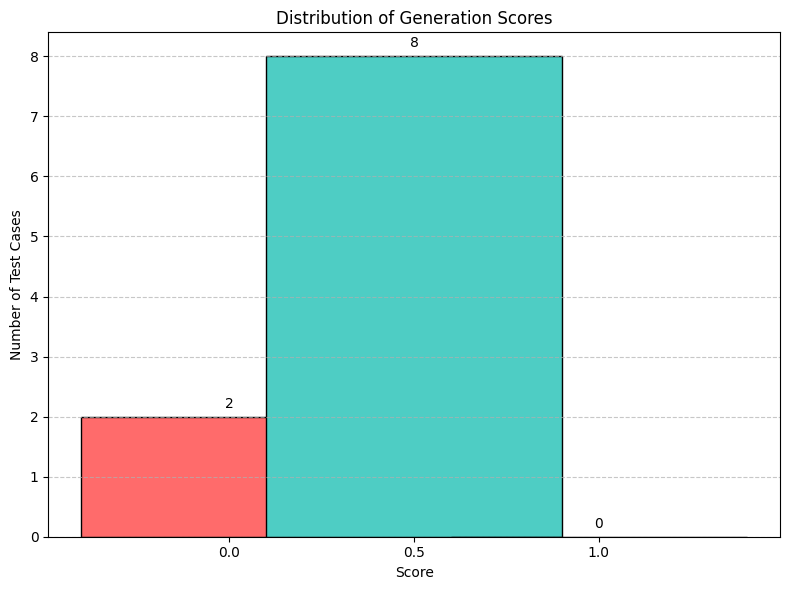

In [26]:
visualize_score_distribution(generation_metrics['Score_Distribution'])

In [ ]:
import gradio as gr
import re

# Function to check if text contains Vietnamese characters
def is_vietnamese(text):
    # Check for Vietnamese diacritic characters
    vietnamese_pattern = re.compile(r'[àảãáạăằẳẵắặâầẩẫấậèẻẽéẹêềểễếệìỉĩíịòỏõóọôồổỗốộơờởỡớợùủũúụưừửữứựỳỷỹýỵđ]', re.UNICODE)
    return bool(vietnamese_pattern.search(text.lower()))

# Define Gradio interface
def gradio_interface(question, top_k=2, show_context=True):
    if not question.strip():
        return {
            "Câu trả lời": "Vui lòng nhập một câu hỏi hợp lệ."
        }

    # Check if question is in Vietnamese
    if not is_vietnamese(question):
        return {
            "Câu trả lời": "Câu hỏi phải được nhập bằng tiếng Việt."
        }

    question, context, response = rag_chain(question, top_k=top_k)
    result = {
        "Câu hỏi": question,
        "Câu trả lời": response
    }
    
    if show_context:
        result["Ngữ cảnh được truy xuất"] = context
    return result

# Define Gradio app
iface = gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Textbox(label="Nhập câu hỏi về lịch sử Việt Nam", placeholder="Ví dụ: Ý nghĩa của chiến thắng Điện Biên Phủ là gì?"),
        gr.Slider(minimum=1, maximum=5, step=1, value=2, label="Số lượng tài liệu truy xuất (top_k)"),
        gr.Checkbox(label="Hiển thị ngữ cảnh được truy xuất", value=True) 
    ],
    outputs=gr.JSON(label="Kết quả RAG"),
    title="Hệ thống Hỏi Đáp Lịch sử Việt Nam với Qwen3-4B-AWQ",
    description="Hệ thống sử dụng mô hình Qwen3-4B-AWQ để trả lời các câu hỏi về lịch sử Việt Nam dựa trên ngữ cảnh được truy xuất. Nhập câu hỏi, chọn số lượng tài liệu, và chọn xem có hiển thị ngữ cảnh hay không.",
    theme=gr.themes.Default()
)

# Launch in Kaggle (use share=False for Kaggle compatibility)
iface.launch(share=True, debug=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://696c75ac87dae0e165.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]